In [21]:
import numpy as np
samples = np.load('data/global_pft_ex.npy')
n_subsample = 800000
subsample_indices = np.random.choice(samples.shape[1], size=n_subsample, replace=False)
# Extract features and target
X = samples[[0, 1, 4], :][:, subsample_indices].T
y = samples[2,subsample_indices]

In [22]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

print(f"Original X shape: {X.shape}")
print(f"Unique PFT values: {np.unique(X[:, 2])}")

# Separate continuous features (SSRD, VPD) from categorical (PFT)
X_continuous = X[:, :2]  # First 2 columns: SSRD, VPD
X_pft = X[:, 2:3]        # Last column: PFT (keep 2D for OneHotEncoder)

# Initialize and fit one-hot encoder
pft_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
X_pft_encoded = pft_encoder.fit_transform(X_pft)

print(f"PFT categories: {pft_encoder.categories_[0]}")
print(f"One-hot encoded PFT shape: {X_pft_encoded.shape}")

# Combine continuous features with one-hot encoded PFT
X_encoded = np.concatenate([X_continuous, X_pft_encoded], axis=1)

print(f"Final X shape after one-hot encoding: {X_encoded.shape}")
print(f"Feature order: [SSRD, VPD, PFT_1.0, PFT_2.0, PFT_3.0]")

# Update X to use the encoded version

Original X shape: (800000, 3)
Unique PFT values: [1. 2. 3.]
PFT categories: [1. 2. 3.]
One-hot encoded PFT shape: (800000, 3)
Final X shape after one-hot encoding: (800000, 5)
Feature order: [SSRD, VPD, PFT_1.0, PFT_2.0, PFT_3.0]


In [6]:
stats_dict = np.load('data/stats_300_pft_ex.npy', allow_pickle=True).item()
ssrd_mean = stats_dict['ssrd_mean']
ssrd_std = stats_dict['ssrd_std']
vpd_mean = stats_dict['vpd_mean']
vpd_std = stats_dict['vpd_std']
gpp_mean = stats_dict['gpp_mean']
gpp_std = stats_dict['gpp_std']

In [23]:
# Normalize your input features X
X_normalized = X_encoded.copy()
X_normalized[:, 0] = (X_encoded[:, 0] - ssrd_mean) / ssrd_std  # SSRD
X_normalized[:, 1] = (X_encoded[:, 1] - vpd_mean) / vpd_std    # VPD

In [24]:
import torch
X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Ensure correct shape

In [25]:
from model import ClimateDataset
from torch.utils.data import DataLoader
# Create DataLoaders
batch_size = 1024  # You can adjust this value based on your available memory and GPU capacity
loader = DataLoader(ClimateDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=False)

In [26]:
from model import NeuralNet
from torch import nn, optim
# Initialize model, loss function, and optimizer
input_dim = 5  # Number of predictors (ssrd and vpd)
model = NeuralNet(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained weights
model.load_state_dict(torch.load('./outputs/model_weights_fine-tuning_pft_ex.pth', map_location=device))
model.to(device)
model.eval()  # Set to evaluation mode

print(f"Model loaded on device: {device}")
print("Pre-trained weights loaded successfully!")

Model loaded on device: cuda
Pre-trained weights loaded successfully!


In [27]:
# Generate predictions using the loaded model
predictions = []
actual_values = []

print("Generating predictions...")
with torch.no_grad():
    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        
        # Store predictions and actual values
        predictions.append(outputs.cpu().numpy())
        actual_values.append(batch_y.cpu().numpy())

# Concatenate all predictions and actual values
predictions = np.concatenate(predictions, axis=0).flatten()
actual_values = np.concatenate(actual_values, axis=0).flatten()

Generating predictions...


In [28]:
predictions = predictions * gpp_std + gpp_mean  # Denormalize predictions

In [29]:
print(f"Generated {len(predictions):,} predictions")
print(f"Prediction range: [{predictions.min():.6f}, {predictions.max():.6f}]")
print(f"Actual range: [{actual_values.min():.6f}, {actual_values.max():.6f}]")

# Calculate some basic metrics
mse = np.mean((predictions - actual_values) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - actual_values))

print(f"\nModel Performance:")
print(f"MSE: {mse:.10f}")
print(f"RMSE: {rmse:.10f}")
print(f"MAE: {mae:.10f}")


Generated 800,000 predictions
Prediction range: [14.573752, 75.244657]
Actual range: [14.128567, 80.707054]

Model Performance:
MSE: 0.9006110643
RMSE: 0.9490053026
MAE: 0.6512457705


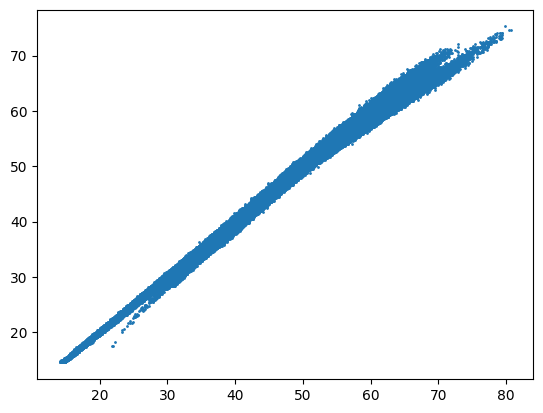

In [30]:
import matplotlib.pyplot as plt
plt.scatter(actual_values, predictions, s=1)

In [31]:
output = np.concatenate((X, predictions.reshape(-1, 1), actual_values.reshape(-1, 1)), axis=1)
output.shape

(800000, 5)

In [32]:
np.save('./outputs/fine_tuning_forward_pft_ex.npy', output)